# Benchmark Models for Predicting Realized Drawdown

This notebook implements benchmark models for predicting **realized drawdown** using only non-text features, specifically **historical volatility (std_dev)**. 

The benchmark approach uses:
- **Features (X)**: Empirical standard deviation [12 trailing months]
- **Target (Y)**: Realized drawdown [12 trailing months]

These benchmarks establish a baseline performance to compare against text-based models (BERT + Linear Regression, BERT + XGBoost) that will be developed later.

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
from constants import DATASET_PATH
df = pd.read_csv(DATASET_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (227634, 6)

Columns: ['gvkey', 'year_month', 'risk_factors_text', 'management_text', 'std_dev', 'realized_drawdown']

First few rows:


,gvkey,year_month,risk_factors_text,management_text,std_dev,realized_drawdown
0,5560.0,2005-08,"item 1 risk factors form 10- k, amended form 1...",item 2 management s discussion analysis financ...,0.243191,-0.230594
1,9325.0,2005-08,item 1- risk factors.,item 2. management' s discussion analysis fina...,0.302114,-0.097688
2,12141.0,2005-08,item 1 risk factors challenges business model ...,item 7. management s discussion analysis finan...,0.160802,-0.189479
3,61567.0,2005-09,item 1a. risk factors 12 item 1a. risk factors...,item 7. management s discussion analysis finan...,0.247901,-0.099658
4,14824.0,2005-11,item 1a risk factors 39 item 1a. risk factors ...,item 2 management s discussion analysis financ...,0.092929,-0.068840


## 2. Exploratory Data Analysis

Before building the benchmark model, let's understand the distribution of our key variables: `std_dev` (historical volatility) and `realized_drawdown` (target variable).

In [ ]:
print("Summary Statistics for Non-Text Features:")
print("="*60)
df[["std_dev", "realized_drawdown"]].describe()

Summary Statistics for Non-Text Features:


,std_dev,realized_drawdown
count,227634.000000,227634.000000
mean,0.470478,-0.306729
std,0.331696,0.216889
min,0.000000,-0.999938
25%,0.256875,-0.431035
50%,0.381751,-0.249621
75%,0.579744,-0.135828
max,3.681053,0.000000


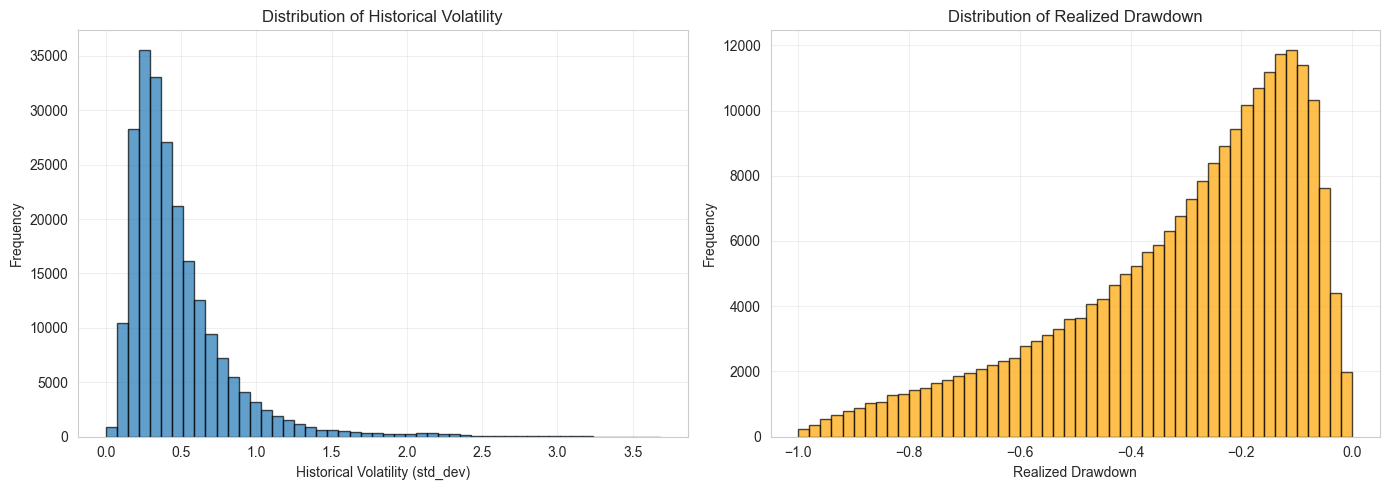

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["std_dev"], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Historical Volatility (std_dev)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Historical Volatility")
axes[0].grid(True, alpha=0.3)

axes[1].hist(df["realized_drawdown"], bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_xlabel("Realized Drawdown")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Realized Drawdown")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

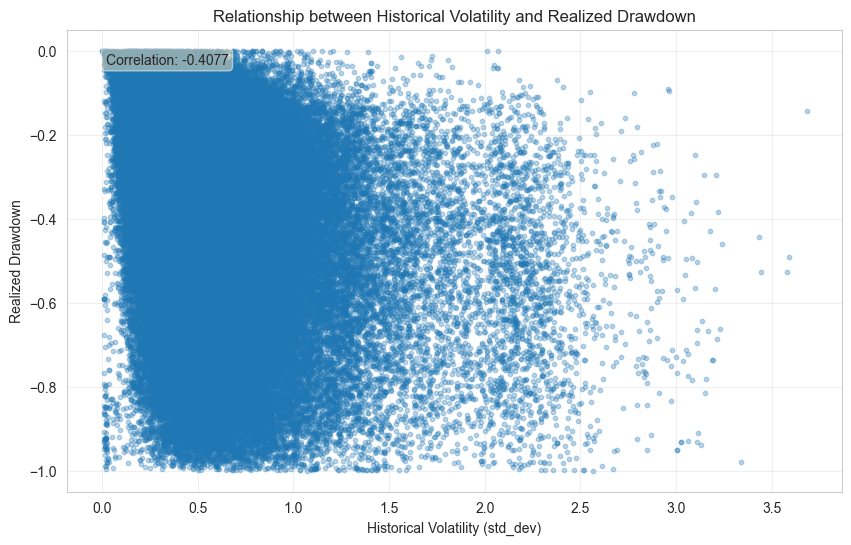

Correlation between std_dev and realized_drawdown: -0.4077


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df["std_dev"], df["realized_drawdown"], alpha=0.3, s=10)
plt.xlabel("Historical Volatility (std_dev)")
plt.ylabel("Realized Drawdown")
plt.title("Relationship between Historical Volatility and Realized Drawdown")
plt.grid(True, alpha=0.3)

correlation = df["std_dev"].corr(df["realized_drawdown"])
plt.text(0.05, 0.95, f"Correlation: {correlation:.4f}", 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
         verticalalignment="top")
plt.show()

print(f"Correlation between std_dev and realized_drawdown: {correlation:.4f}")

## 3. Data Preparation

We'll prepare the data for modeling by:
1. Extracting the feature (std_dev) and target (realized_drawdown)
2. Splitting into training and test sets (80/20 split)
3. Using a fixed random state for reproducibility

In [ ]:
X = df[["std_dev"]].values
y = df["realized_drawdown"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature dimensionality: {X_train.shape[1]}")

Training set size: 182107 samples
Test set size: 45527 samples
Feature dimensionality: 1


## 4. Benchmark Model: Linear Regression

The benchmark model uses a simple **Linear Regression** to predict realized drawdown from historical volatility. This serves as the baseline that more sophisticated models (with text embeddings) need to beat.

**Model equation:** 
$$\text{realized\_drawdown} = \beta_0 + \beta_1 \times \text{std\_dev}$$

In [ ]:
benchmark_model = LinearRegression()
benchmark_model.fit(X_train, y_train)


y_train_pred = benchmark_model.predict(X_train)
y_test_pred = benchmark_model.predict(X_test)


print("Model Parameters:")
print("="*60)
print(f"Intercept (beta_0): {benchmark_model.intercept_:.6f}")
print(f"Coefficient for std_dev (beta_1): {benchmark_model.coef_[0]:.6f}")
print(f"\nModel equation:")
print(f"realized_drawdown = {benchmark_model.intercept_:.6f} + {benchmark_model.coef_[0]:.6f} * std_dev")

Model Parameters:
Intercept (β₀): -0.181161
Coefficient for std_dev (β₁): -0.266143

Model equation:
realized_drawdown = -0.181161 + -0.266143 × std_dev


## 5. Model Evaluation

We evaluate the benchmark model using multiple metrics:
- **R^2 Score**: Proportion of variance explained by the model (higher is better)
- **Mean Squared Error (MSE)**: Average squared prediction error (lower is better)
- **Root Mean Squared Error (RMSE)**: Square root of MSE, in same units as target (lower is better)
- **Mean Absolute Error (MAE)**: Average absolute prediction error (lower is better)

In [ ]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print("Benchmark Model Performance:")
print("="*60)
print(f"\nTraining Set:")
print(f"  R^2 Score:  {train_r2:.6f}")
print(f"  MSE:       {train_mse:.6f}")
print(f"  RMSE:      {train_rmse:.6f}")
print(f"  MAE:       {train_mae:.6f}")

print(f"\nTest Set (Out-of-Sample):")
print(f"  R^2 Score:  {test_r2:.6f}")
print(f"  MSE:       {test_mse:.6f}")
print(f"  RMSE:      {test_rmse:.6f}")
print(f"  MAE:       {test_mae:.6f}")


results_df = pd.DataFrame({
    "Metric": ["R^2 Score", "MSE", "RMSE", "MAE"],
    "Training": [train_r2, train_mse, train_rmse, train_mae],
    "Test": [test_r2, test_mse, test_rmse, test_mae]
})

print("\n\nSummary Table:")
print(results_df.to_string(index=False))

Benchmark Model Performance:

Training Set:
  R² Score:  0.166084
  MSE:       0.039167
  RMSE:      0.197906
  MAE:       0.156435

Test Set (Out-of-Sample):
  R² Score:  0.166629
  MSE:       0.039445
  RMSE:      0.198607
  MAE:       0.157173


Summary Table:
  Metric  Training     Test
R² Score  0.166084 0.166629
     MSE  0.039167 0.039445
    RMSE  0.197906 0.198607
     MAE  0.156435 0.157173


## 6. Visualization of Results

Let's visualize how well the model predictions match the actual realized drawdowns.

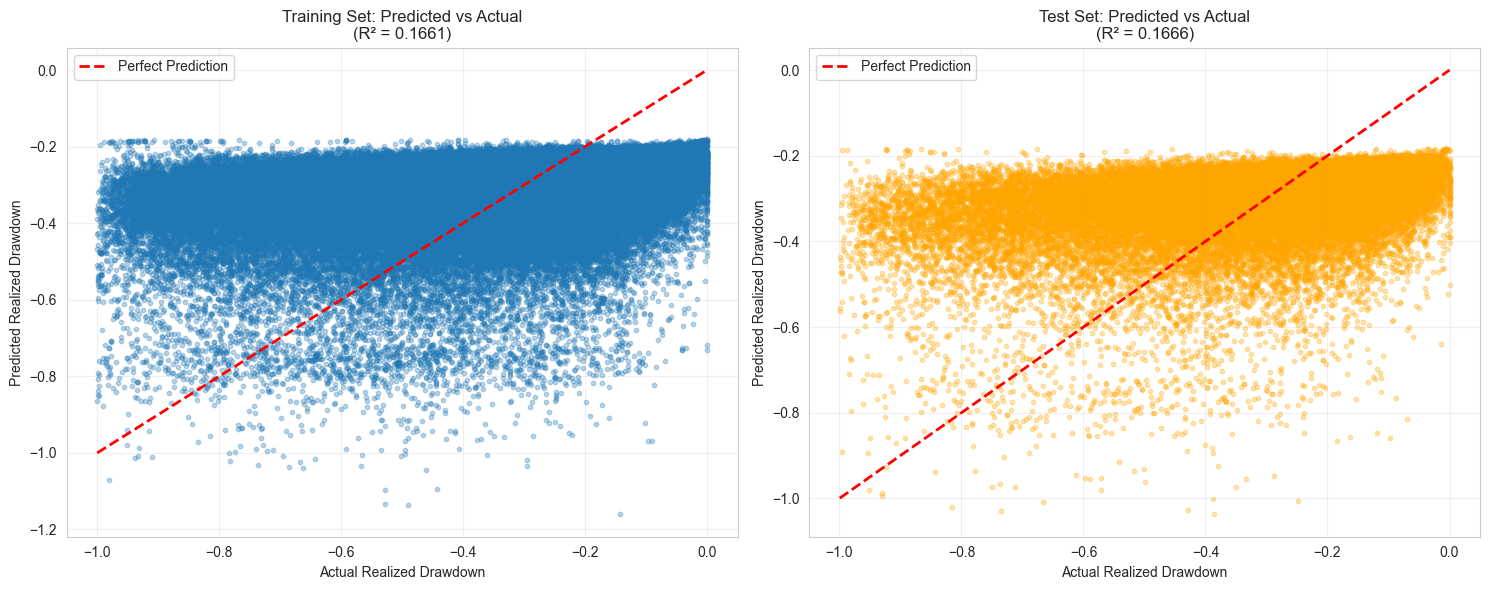

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             "r--", lw=2, label="Perfect Prediction")
axes[0].set_xlabel("Actual Realized Drawdown")
axes[0].set_ylabel("Predicted Realized Drawdown")
axes[0].set_title(f"Training Set: Predicted vs Actual\n(R² = {train_r2:.4f})")
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=10, color="orange")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             "r--", lw=2, label="Perfect Prediction")
axes[1].set_xlabel("Actual Realized Drawdown")
axes[1].set_ylabel("Predicted Realized Drawdown")
axes[1].set_title(f"Test Set: Predicted vs Actual\n(R² = {test_r2:.4f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

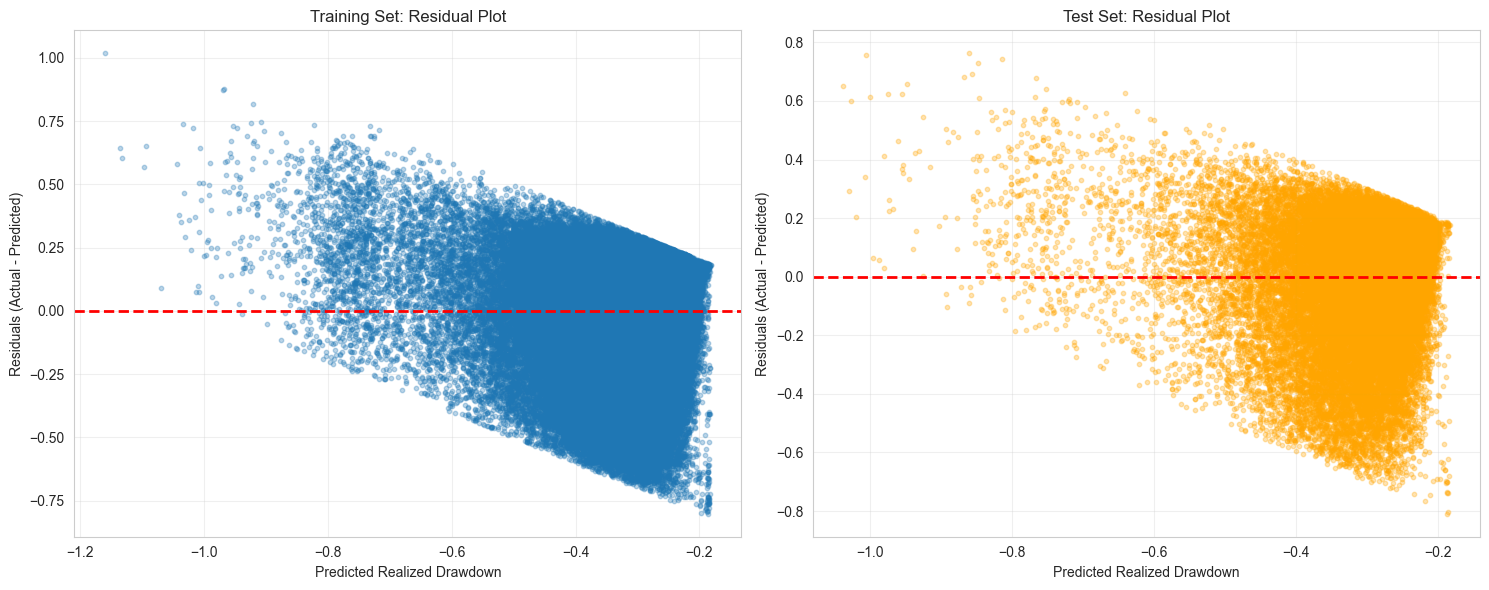

In [ ]:
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


axes[0].scatter(y_train_pred, residuals_train, alpha=0.3, s=10)
axes[0].axhline(y=0, color="r", linestyle="--", lw=2)
axes[0].set_xlabel("Predicted Realized Drawdown")
axes[0].set_ylabel("Residuals (Actual - Predicted)")
axes[0].set_title("Training Set: Residual Plot")
axes[0].grid(True, alpha=0.3)


axes[1].scatter(y_test_pred, residuals_test, alpha=0.3, s=10, color="orange")
axes[1].axhline(y=0, color="r", linestyle="--", lw=2)
axes[1].set_xlabel("Predicted Realized Drawdown")
axes[1].set_ylabel("Residuals (Actual - Predicted)")
axes[1].set_title("Test Set: Residual Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Findings and Interpretation

### Model Performance Summary

The benchmark linear regression model uses only **historical volatility (std_dev)** to predict **realized drawdown**. 

**Key Observations:**

1. **Baseline R^2 Score**: The test set R^2 score represents the proportion of variance in realized drawdown that can be explained by historical volatility alone. This serves as the baseline that text-based models need to exceed.

2. **Predictive Power of Volatility**: The correlation and R^2 metrics indicate how well past volatility predicts future drawdowns.

In [ ]:
print("Benchmark results saved for future comparison.")
print("\nBaseline Test R^2 Score:", f"{test_r2:.6f}")
print("This is the target to beat with text-enhanced models!")

Benchmark results saved for future comparison.

Baseline Test R² Score: 0.166629
This is the target to beat with text-enhanced models!
